# ANN price forecasting

In [10]:
import torch

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from model import ElectricityPricePredictor, train_model, get_model_predictions
from data_process import *

import csv

### Using the data from energymarketprice

In [11]:
df = csv_to_dataframe()
# df.head()

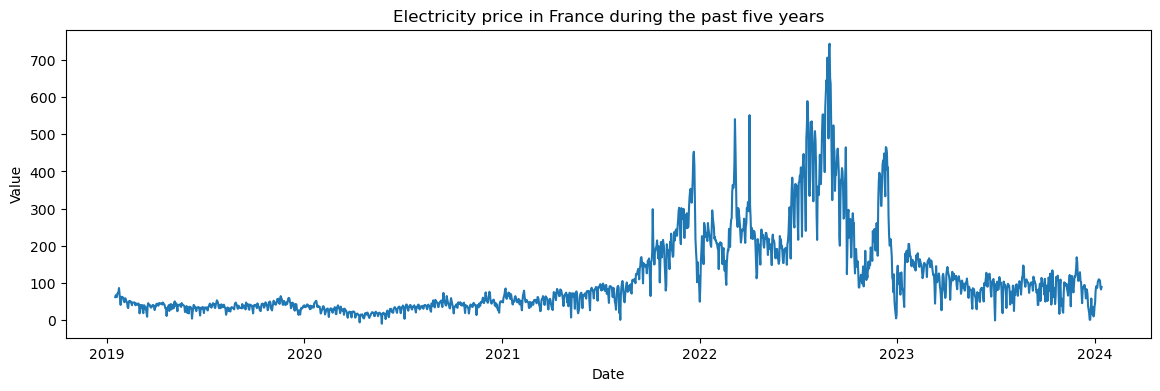

In [12]:
lineplot_from_dataframe(df, 'Date', 'Value', 'Electricity price in France during the past five years')

In [13]:
consumption_predictions = get_consumption_data()

In [15]:
df = merge_dataframes(df, consumption_predictions)

In [16]:
nn_df = prepare_df_for_price_forecasting(df)
nn_df.head()

,Value,Forecasted demand1,Forecasted demand2,Forecasted demand3,Change in demand1,Change in demand2,Change in demand3,Day of Week,value_two_days_before,value_one_week_before1,value_one_week_before2,value_two_weeks_before1,value_two_weeks_before2,value_three_weeks_before1,value_three_weeks_before2,value_four_weeks_before1,value_four_weeks_before2,value_to_predict
0,44.03,66446.5625,72385.3125,66351.5625,-1523.0625,-1442.1250,-2498.1875,5,48.85,33.78,47.39,50.21,59.49,54.39,69.53,63.87,66.68,39.67
1,39.67,61335.8125,62712.8125,59867.6875,-5110.7500,-9672.5000,-6483.8750,6,44.03,32.09,33.78,47.78,50.21,40.53,54.39,61.54,63.87,47.02
2,47.02,57165.1250,57320.4375,57846.3125,-4170.6875,-5392.3750,-2021.3750,7,39.67,47.13,32.09,57.23,47.78,55.89,40.53,71.51,61.54,47.02
3,47.02,60252.6250,69855.8750,66529.1875,3087.5000,12535.4375,8682.8750,1,47.02,51.39,47.13,58.36,57.23,62.67,55.89,72.32,71.51,47.16
4,47.16,62087.1250,71086.6250,67422.0000,1834.5000,1230.7500,892.8125,2,47.02,49.70,51.39,52.99,58.36,59.18,62.67,76.07,72.32,47.03


In [17]:
X = torch.tensor(nn_df.drop("value_to_predict", axis=1).values, dtype=torch.float)
y = torch.tensor(nn_df["value_to_predict"].values, dtype=torch.float).unsqueeze(1)
train_loader, test_loader, y_test, num_inputs = prepare_datasets_for_model(X, y, 1, 1)

In [18]:
model = ElectricityPricePredictor(input_size=num_inputs)

loss = train_model(model, train_loader)
y_pred = get_model_predictions(model, test_loader)

Epoch: 100%|██████████| 20/20 [01:25<00:00,  4.27s/epoch]


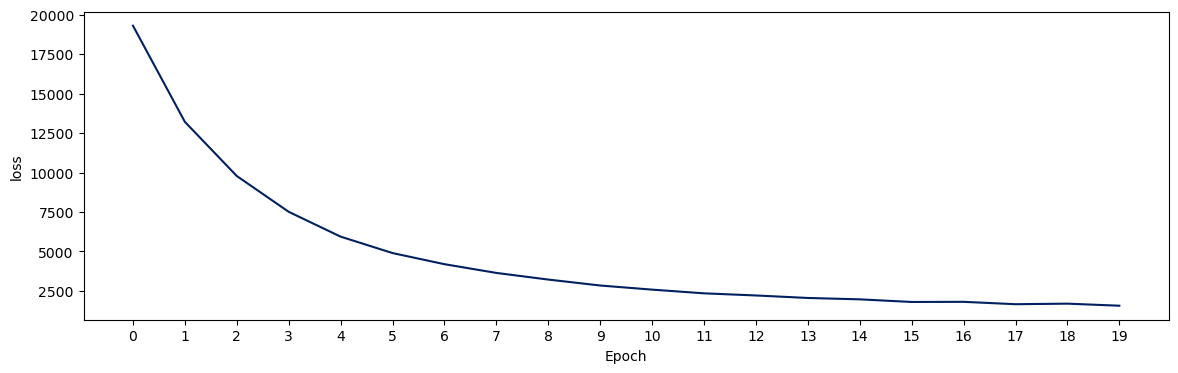

In [19]:
plt.figure(figsize=(14,4))
plt.plot(loss, color="#002060")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.xticks([x for x in range(len(loss))])
plt.show()

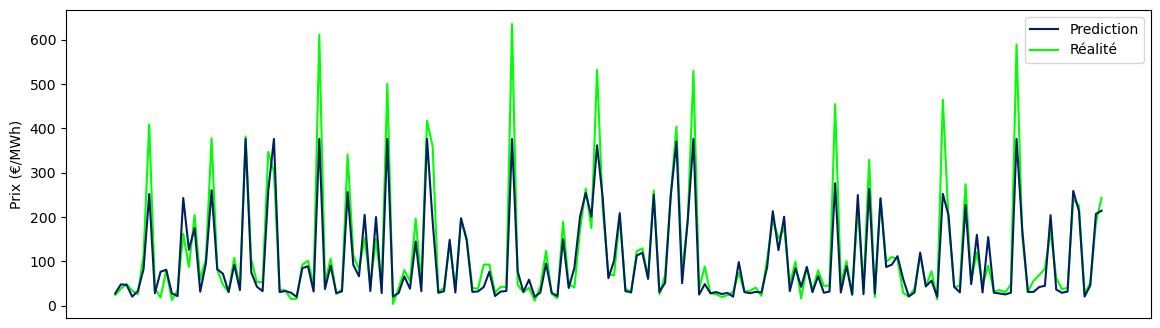

In [20]:
plt.figure(figsize=(14,4))
plt.plot(y_pred, color="#002060", label="Prediction", zorder=2)
plt.plot(y_test, color="#00FF00", label="Réalité", zorder=1)
plt.ylabel("Prix (€/MWh)")
plt.xticks([])
plt.legend()
plt.show()

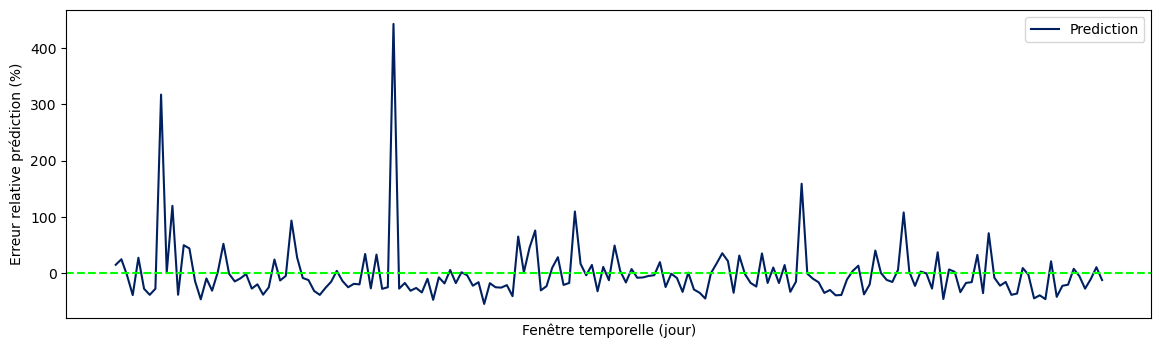

In [21]:
prediction_error = (np.array(y_pred) - y_test.numpy())/y_test.numpy() * 100

plt.figure(figsize=(14,4))
plt.plot(prediction_error, color="#002060", label="Prediction", zorder=2)
plt.axhline(y=0, color='#00FF00', linestyle='--')
plt.ylabel("Erreur relative prédiction (%)")
plt.xlabel("Fenêtre temporelle (jour)")
plt.xticks([])
plt.legend()
plt.show()

In [22]:
with open('../web-app/src/pages/home/utils/data.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    spamwriter.writerow(["date", "prediction", "reality"])
    for row in range( len( y_pred ) ):
        spamwriter.writerow([row, y_pred[row], y_test[row].item()])

In [23]:
(error, positive_error) = get_stats_from_result( prediction_error )

In [24]:
error

,99%,95%,90%,75%,50%
0,3.428571,14.857143,25.142857,58.285714,93.142857


In [25]:
positive_error

,99%,95%,90%,75%,50%
0,66.857143,73.142857,77.142857,85.142857,93.714286


https://appsilon.com/pytorch-neural-network-tutorial/

In [26]:
min_mse = 100000000
max_mse = -1
for x in range(len(y_test) - 24):
    mse = mean_squared_error(y_test[x:x+24], y_pred[x:x+24])
    if mse < min_mse:
        min_mse = mse
    if mse > max_mse:
        max_mse = mse

print(f"MSE min: {min_mse}")
print(f"RMSE min: {np.sqrt(min_mse)}", end="\n\n")

print(f"MSE max: {max_mse}")
print(f"RMSE max: {np.sqrt(max_mse)}", end="\n\n")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")

MSE min: 272.8772277832031
RMSE min: 16.51899528503418

MSE max: 5059.02880859375
RMSE max: 71.12684631347656

MSE: 2722.607421875
RMSE: 52.178611755371094


# Using the data of the EPEX spot

In [113]:
write_csv(number_of_years=2, force=True)
df = epex_csv_to_dataframe()

U = 290

print(np.sum(df.values[:,-1]<U)/df.values.shape[0]*100)

#df['price_euros_mwh'] = df['price_euros_mwh'].apply(lambda x: U + U * np.log(x / U) if x > U else x)
df["value_to_predict"] = df["price_euros_mwh"].shift(-24)

df = df.reset_index(drop=True)

97.50144258511251


In [114]:
path_2021 = "../data/RTE_demand/prevision_conso_2021.csv"
demand_df_2021 = pd.read_csv(path_2021, sep=";")

path_2020 = "../data/RTE_demand/prevision_conso_2020.csv"
demand_df_2020 = pd.read_csv(path_2020, sep=";")

demand_df = pd.concat([demand_df_2020, demand_df_2021], ignore_index=True)

demand_df = pd.melt(demand_df, id_vars=['Jours/Heures'], var_name='Heure', value_name='demand')
demand_df.rename(columns={'Jours/Heures': 'date', "Heure" : "hour"}, inplace=True)
demand_df = demand_df[demand_df['hour'].str[-2:] == '00']

demand_df['date'] = pd.to_datetime(demand_df['date'], format=' %d/%m/%Y').dt.date
demand_df['hour'] = pd.to_datetime(demand_df['hour'], format='%H:%M').dt.hour
demand_df = demand_df.sort_values(by=['date', 'hour'])
demand_df = demand_df.reset_index(drop=True)

In [115]:
demand_df["change_in_demand"] = demand_df["demand"].diff()

In [116]:
df = pd.merge(df, demand_df, on=['date','hour'])
df = df.reset_index(drop=True)

In [117]:
# Three values for today
df["value2"] = df["price_euros_mwh"].shift(1)
df["value3"] = df["price_euros_mwh"].shift(2)

df["value_one_week_before1"] = df["price_euros_mwh"].shift(24*7 + 1)
df["value_one_week_before2"] = df["price_euros_mwh"].shift(24*7)
df["value_one_week_before3"] = df["price_euros_mwh"].shift(24*7 - 1)

df["value_two_weeks_before"] = df["price_euros_mwh"].shift(24*14)

df["value_three_weeks_before"] = df["price_euros_mwh"].shift(24*21)

df["value_four_weeks_before"] = df["price_euros_mwh"].shift(24*28)

In [118]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop("date", axis=1, inplace=True)
df.head()

,hour,day_of_week,price_euros_mwh,value_to_predict,demand,change_in_demand,value2,value3,value_one_week_before1,value_one_week_before2,value_one_week_before3,value_two_weeks_before,value_three_weeks_before,value_four_weeks_before
0,23,3,42.71,42.02,63925,2649.0,45.51,51.02,42.40,35.95,28.95,48.98,57.45,50.87
1,0,4,38.25,40.17,62402,-1523.0,42.71,45.51,35.95,28.95,25.71,48.66,56.41,48.19
2,1,4,33.66,37.90,58521,-3881.0,38.25,42.71,28.95,25.71,23.96,47.70,55.17,44.68
3,2,4,29.99,36.27,58996,475.0,33.66,38.25,25.71,23.96,23.03,46.60,51.76,42.92
4,3,4,29.00,34.86,55925,-3071.0,29.99,33.66,23.96,23.03,35.38,48.00,50.86,40.39


In [119]:
X = torch.tensor(df.drop("value_to_predict", axis=1).values, dtype=torch.float)
y = torch.tensor(df["value_to_predict"].values, dtype=torch.float).unsqueeze(1)
train_loader, test_loader, y_test, num_inputs = prepare_datasets_for_model(X, y, 8, 4)

In [120]:
model = ElectricityPricePredictor(input_size=num_inputs)

loss = train_model(model, train_loader)
y_pred = get_model_predictions(model, test_loader)

Epoch: 100%|██████████| 20/20 [01:37<00:00,  4.90s/epoch]


In [121]:
'''reverse_fun = lambda x: U * np.exp(x/U - 1) if x > U else x
for i in range(len(y_pred)):
    y_pred[i] = reverse_fun(y_pred[i])'''

'reverse_fun = lambda x: U * np.exp(x/U - 1) if x > U else x\nfor i in range(len(y_pred)):\n    y_pred[i] = reverse_fun(y_pred[i])'

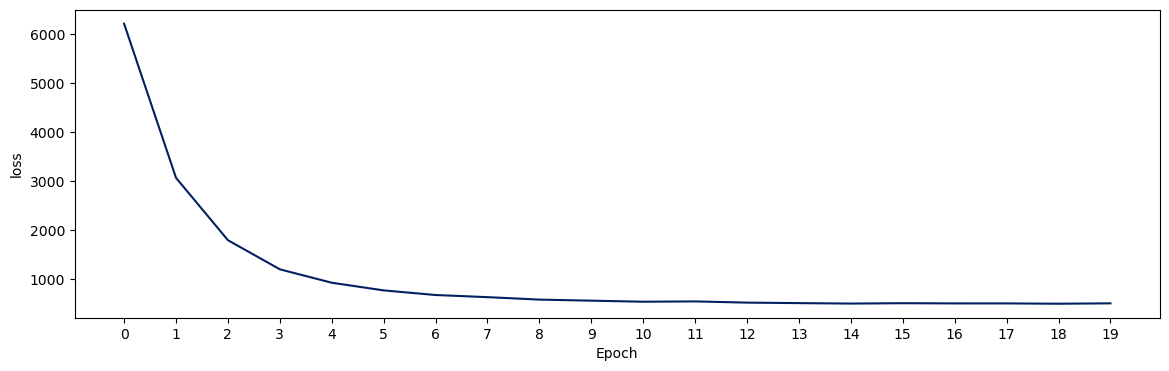

In [122]:
plt.figure(figsize=(14,4))
plt.plot(loss, color="#002060")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.xticks([x for x in range(len(loss))])
plt.show()

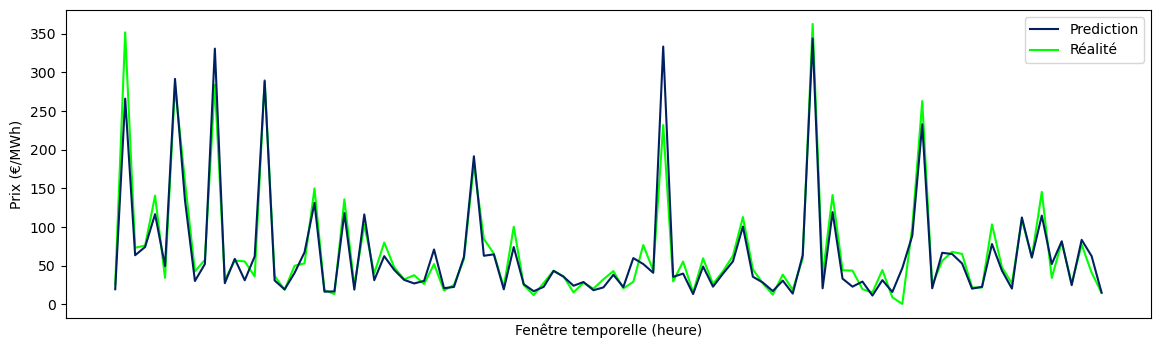

In [123]:
plt.figure(figsize=(14,4))
plt.plot(y_pred[:100], color="#002060", label="Prediction", zorder=2)
plt.plot(y_test[:100], color="#00FF00", label="Réalité", zorder=1)
plt.ylabel("Prix (€/MWh)")
plt.xlabel("Fenêtre temporelle (heure)")
plt.xticks([])
plt.legend()
plt.show()

In [124]:
prediction_error = (np.array(y_pred) - y_test.numpy())/y_test.numpy() * 100
(error, positive_error) = get_stats_from_result( prediction_error )

print(error)
print(positive_error)

       99%        95%        90%        75%        50%
0  2.95003  16.556291  33.835039  74.593618  92.113185
         99%        95%       90%        75%        50%
0  66.345575  72.968092  79.10897  88.500903  93.678507


In [125]:
min_mse = 100000000
max_mse = -1
for x in range(len(y_test) - 24):
    mse = mean_squared_error(y_test[x:x+24], y_pred[x:x+24])
    if mse < min_mse:
        min_mse = mse
    if mse > max_mse:
        max_mse = mse

print(f"MSE min: {min_mse}")
print(f"RMSE min: {np.sqrt(min_mse)}", end="\n\n")

print(f"MSE max: {max_mse}")
print(f"RMSE max: {np.sqrt(max_mse)}", end="\n\n")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")

MSE min: 37.61405563354492
RMSE min: 6.133029937744141

MSE max: 2050.667724609375
RMSE max: 45.284297943115234

MSE: 508.4119567871094
RMSE: 22.547992706298828
